   #                        Resume Parsing using OCR with NER
   
   **Nafas Gul Saadat** - M.Tech Softwate Engineering

###  The process of this project is divided into 7 steps
 
 ### First Step: Data Collection    
  Download resumes Images, PDFs form internet 
  
 ### Second:  Install Requare Packages        
 **OCR**  
Optical Character Recognition (OCR) is a technology to recognize text inside images, such as scanned document and photos. It is used to convert virtually any kind of images containing written text into machine readable text data.    
 There are two frameworks for using OCR:  
           **•	Tesseract:** Better at letter recognition   
           **•	EasyOCR:** Better at number recognition     
install: pip install pytesseract  
install: pip install pillow PLE  
install: pip install PyMuPDF,pdfminer    
install: pip install docx2txt   
 **NER**  
   Name Entity Recongnation in NLP  
install : pip install spacy  
install : python -m spacy download en_core_web_sm  
install : pinp install nltk  
 

### Third: Extract text form images using OCR and OpenCV 
  1- Convert images and pdfs to machine readable text and save in .txt file


In [221]:
import pytesseract as tess
from PIL import Image
import cv2
from matplotlib import pyplot as plt

tess.pytesseract.tesseract_cmd = r'C:\Users\TAQI\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

img = cv2.imread('mycv.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

text=pytesseract.image_to_string(img)
print(text)

file = open("MyCV.txt", "a") 
file.write(text) 
file.write("\n") 
file.close 

hImg, wImg,_ = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
    b = b.split(' ')
    x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
    cv2.rectangle(img, (x,hImg- y), (w,hImg- h), (50, 50, 255), 2)
    cv2.putText(img,b[0],(x,hImg- y+25),cv2.FONT_HERSHEY_SIMPLEX,1,(50,50,255),2)
#plt.imshow(img)
#plt.show()


cv2.imshow('img', img)
cv2.waitKey(0)

-1

**2-Using Pdfminer,Extract text from pdf and save in txt format (more than one pages)**

In [91]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfparser import PDFParser
import io
import os

fp = open('Smith Resume.pdf', 'rb')
rsrcmgr = PDFResourceManager()
retstr = io.StringIO()
print(type(retstr))
codec = 'utf-8'
laparams = LAParams()
device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)

page_no = 0
for pageNumber, page in enumerate(PDFPage.get_pages(fp)):
    if pageNumber == page_no:
        interpreter.process_page(page)

        data = retstr.getvalue()

        with open(os.path.join('', f'pdf page {page_no}.txt'), 'wb') as file:
            file.write(data.encode('utf-8'))
        data = ''
        retstr.truncate(0)
        retstr.seek(0)

    page_no += 1

<class '_io.StringIO'>


### Fourth: Data Preprocessing
    - Remove Punctuations, Space  
    - Tokanization 
    - Annotation
    - Convert to Spacy Format
    
  I used nltk for Tokenization and annotation but it was not accurate and did not annotate accurately     
  Then I used this annotator tool:  http://agateteam.org/spacynerannotate  to annotate my dataset manually.   
  I used each extracted .txt file(each resume) and Annotate using the above tool.   
    

In [219]:
# not tokenize appropriately
import nltk
import string
import spacy
from nltk import sent_tokenize
from pdfminer.high_level import extract_text

nlp = spacy.load('en_core_web_sm')


pdf_path='C:\\Users\\TAQI'
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
text1 =extract_text_from_pdf('Nafas Gul Saadat.pdf')

words = text1.split()
newfile=" ".join(words)
print(newfile)

# remove puctuations
remove = string.punctuation
remove = remove.replace("@", "") # don't remove @
pattern = r"[{}]".format(remove) # create the pattern
re.sub(pattern, "", newfile) 


# Tokenization using nltk
for sent in nltk.sent_tokenize(newfile):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
        if hasattr(chunk, 'label'):
            print(chunk.label(), ' '.join(c[0] for c in chunk))

# Tokenize using spacy
#doc = nlp(newfile)
#for ent in doc.ents:
#    print(ent.text, ent.start_char, ent.end_char, ent.label_)       

#### 3- Serialization of Training data (Convert dataset .txt file  into byte string picke(.pkl) ) 
 Spacy Documentaion: https://spacy.io/usage/saving-loading


In [263]:
import pickle #credits to stack overflow user= blender

import glob
import spacy
nlp = spacy.load("en_core_web_sm")
path = 'train_data2.txt'

text=""
for file in glob.glob(path):
    with open(file, encoding='utf-8', errors='ignore') as file_in:
    text = file_in.read()
      
print(text)

with open('training_data.pkl', 'wb') as handle:
    pickle.dump(text, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('training_data.pkl', 'rb') as handle:
#    b = pickle.load(handle)

#print (b)


### Fifth: Load Dataset and Train our Model 
Load the .pkl dataset file and train model using SpaCy with **10 iteration** 

In [61]:
import spacy
import pickle
import random

train_data = pickle.load(open('train_data.pkl', 'rb'))
nlp = spacy.blank('en')

def train_model(train_data):
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True)
    
    for _, annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2])
            
    
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(10):
            print("Statring iteration " + str(itn))
            random.shuffle(train_data)
            losses = {}
            index = 0
            for text, annotations in train_data:
                try:
                    nlp.update(
                        [text],  
                        [annotations],  
                        drop=0.2,  
                        sgd=optimizer,  
                        losses=losses)
                except Exception as e:
                    pass
                
            print(losses)
            
train_model(train_data)

Statring iteration 0
{'ner': 16427.639587293037}
Statring iteration 1
{'ner': 12680.517310063442}
Statring iteration 2
{'ner': 7399.085914339747}
Statring iteration 3
{'ner': 7077.066855054343}
Statring iteration 4
{'ner': 6332.998354287544}
Statring iteration 5
{'ner': 6776.1108261353265}
Statring iteration 6
{'ner': 5874.083381202595}
Statring iteration 7
{'ner': 5481.285504961391}
Statring iteration 8
{'ner': 4175.002448393061}
Statring iteration 9
{'ner': 4487.716465659495}


#### Save our model to disk

In [62]:
nlp.to_disk('nlp_model_parser')

#### Load our trained  model 

In [63]:
nlp_model_parser = spacy.load('nlp_model_parser')

### Test our model with Trained Data

In [77]:
doc = nlp_model_parser(train_data[1][0])
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Bike Rally
DESIGNATION                   - Chief Coordinator of LEAR
COMPANIES WORKED AT           - Palghat, Kerala - Email me on Indeed: indeed.com/r/Bike-Rally/e00d408e91e83868  Education  WORK EXPERIENCE  Chief Coordinator of LEAR
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
DEGREE                        - MBA in marketing-tourism
COLLEGE NAME                  - Calicut University
GRADUATION YEAR               - 2018


### Sixth:  Now test our model on  unseen resumes
**Our model has some errors and is not accurate because it is trained with a smaller amount of dataset**

In [78]:
import sys, fitz
fname = 'Alice Clark CV.pdf'
doc = fitz.open(fname)
text = ""
for page in doc:
    text = text + str(page.getText())

tx = " ".join(text.split('\n'))
#print(tx)

In [79]:
doc = nlp_model_parser(tx)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Alice Clark
LOCATION                      - Delhi
DESIGNATION                   - Software Engineer
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COLLEGE NAME                  - Indian Institute of Technology – Mumbai
SKILLS                        - Machine Learning, Natural Language Processing, and Big Data Handling    ADDITIONAL INFORMATION  Professional Skills  • Excellent analytical, problem solving, communication, knowledge transfer and interpersonal


In [80]:
import sys, fitz
fname = 'Nafas Gul Saadat2.pdf'
doc = fitz.open(fname)
text = ""
for page in doc:
    text = text + str(page.getText())

tx = " ".join(text.split('\n'))
#print(tx)

In [81]:
doc = nlp_model_parser(tx)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Nafas GulSaadat
DESIGNATION                   - Software Engineer
GRADUATION YEAR               - 8951269621
DESIGNATION                   - Software Engineer
DEGREE                        - B.Sc
COLLEGE NAME                  - Kabul Polytechnic University
GRADUATION YEAR               - 2017


In [82]:
import sys, fitz
fname = 'Smith Resume.pdf'
doc = fitz.open(fname)
text = ""
for page in doc:
    text = text + str(page.getText())

tx = " ".join(text.split('\n'))
#print(tx)

In [83]:
doc = nlp_model_parser(tx)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Michael Smith
EMAIL ADDRESS                 - indeed.com/r/falicent/140749dace5dc26f
LOCATION                      - Technologies
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COLLEGE NAME                  - The University of Manchester - UK  2007
SKILLS                        - problem solving (Less than 1 year), project lifecycle (Less than 1 year), project


### Seventh : Create a Simple UI
User can select a pdf file and the system summarize and saves the list of summarized CVs to a .txt file, user can open the .txt file and can edit and print


In [87]:
from tkinter import *
import os
import sys, fitz
from tkinter import Label
import numpy
from tkinter import filedialog
import pickle #credits to stack overflow user= blender
from tkinter import Toplevel, Button, Tk, Menu, Frame, Text, Scrollbar, RIGHT, Y, filedialog, Label, END
import glob
import spacy
import win32print
import win32api

nlp = spacy.load("en_core_web_sm")
win = Tk()
win.title("Welcome to Resume Parser")
win.iconbitmap("C:/Users/TAQI/res.jpg")

win.geometry("800x500")

#Load our Model
nlp_model_parser = spacy.load('nlp_model_parser')

# Create txt file for saving summarized resumes
file1 = open("ForPrint.txt","a")
basename=" "
filename1=" "

def openfile():
  global basename
  win.filename=filedialog.askopenfilename(initialdir="C:/Users/TAQI/",title="Select File",filetypes=[('Pdf Files', '*.pdf'),('All file',"*.*")])
  
  filename1=win.filename
  basename = os.path.basename(win.filename)
  my_lable=Label(win,text=basename,font=("arial",10,"bold")).grid(row=2,column=0,sticky='ESW',padx=2,pady=5)
  doc = fitz.open(basename)
  text = ""
  for page in doc:
    text = text + str(page.getText())

  tx = " ".join(text.split('\n'))
  doc = nlp_model_parser(tx)
  i=6
  for ent in doc.ents:
     i=i+1
     print(f'{ent.label_.upper():{30}}- {ent.text}')
     text=f'{ent.label_.upper():{30}}- {ent.text}'
     showlabel1=Label(win,text=ent.text,justify="left",bd=1,relief="sunken").grid(row=i, column=2, sticky='ESW',padx=2,pady=4)
     showlabel2=Label(win,text=ent.label_.upper(),justify="left",bd=1,relief="sunken").grid(row=i, column=0, sticky='ESW',padx=2,pady=4)
     file1 = open("ForPrint.txt","a")
     file1.write(text+"\n")
     

file1.close()
print(basename)

mylable=Label(win,text="Welcome to Resume Parser",font=("arial",16,"bold")).grid(row=0,column=2)
mylabel2=Label(win,text="Please Upload Your Resume  :",font=("arial",9,"bold")).grid(row=1,column=0)
btnselect=Button(win,text="Open File",command=openfile).grid(row=1,column=1)
mynamelabel=Label(win,text="Your Information").grid(row=2,column=0,sticky='ESW',padx=3,pady=5)

class App(Frame):
    def __init__(self, master):
        Frame.__init__(self, master)
        self.grid()
        self.widgets()


    def widgets(self):
        menubar = Menu(win)
        file = Menu(menubar, tearoff=0)
        file.add_command(label="New",command = Open)
        file.add_command(label="Open",command=open_new)
        file.add_command(label="Close")

        file.add_separator()

        file.add_command(label="Exit", command=win.quit)

        menubar.add_cascade(label="File", menu=file)
        edit = Menu(menubar, tearoff=0)
        
        help = Menu(menubar, tearoff=0)
        help.add_command(label="About")
        menubar.add_cascade(label="Help", menu=help)

        win.config(menu=menubar)

    
def open_new():
    newwin=Tk()
    newwin.title("Open Text")
    newwin.geometry("800x660")
    my_fram=Frame(newwin)
    my_fram.pack(pady=5)
    text_scroll = Scrollbar(my_fram)
    text_scroll.pack(side=RIGHT,fill=Y)
    mytext=Text(my_fram,width=90,height=25,font=("Helvetica",16),selectbackground="yellow",selectforeground="black",
                undo=True,yscrollcommand=text_scroll.set)

    mytext.pack()

    text_scroll.config(command=mytext.yview)
    
    def Open_new():
        mytext.delete("1.0",END)
        newwin.title("New Window")
        #status_bar.config(text="New File   ")
    
    def open_file():
        print("hellooookdfjsl")
        mytext.delete("1.0",END)
        textfile=filedialog.askopenfilename(initialdir="C:/Users/TAQI/", title="Select File",
                                             filetypes=[('Text file', "*.txt")])
        name=textfile
        name=name.replace(" "," ")
        newwin.title(name)
        text_file=open(textfile,'r')
        stuff=text_file.read()
        #Add file to text box
        mytext.insert(END,stuff)
        text_file.close()
        
    def save_as_file():
        txt_file=filedialog.askopenfilename(defaultextension=".*",initialdir="C:/Users/TAQI/", title="Select File",
                                             filetypes=[('Text file', "*.txt"),('Pdf file', "*.pdf")])
        
        if txt_file:
            name=txt_file
            name=name.replace(" "," ")
            newwin.title(name)
        txt_filesave=open_file(txt_file,'w')
        txt_filesave.write(mytext.get(1.0,END))
        txt_filesave.close()
        
        
    def Print_func():
        
        printer_name=win32print.GetDefaultPrinter()
        print_file = filedialog.askopenfilename(defaultextension=".*", initialdir="C:/Users/TAQI/", title="Select File",
                                              filetypes=[('Text file', "*.txt"), ('Pdf file', "*.pdf")])
        if print_file:
            win32api.ShellExecute(0,"print",print_file,None,".",0)

    
    
    class App2(Frame):
        def __init__(self, master):
            Frame.__init__(self, master)
            #self.grid()
            self.widgets()
        
        def widgets(self):
            menubar = Menu(newwin)
            file = Menu(menubar, tearoff=0)
            file.add_command(label="New", command=Open_new)
            file.add_command(label="Open", command=open_file)
            file.add_command(label="Save",command="")
            file.add_command(label="Save as...",command=save_as_file)
            file.add_command(label="Print",command=Print_func)
            file.add_command(label="Close")

            file.add_separator()

            file.add_command(label="Exit", command=win.quit)

            menubar.add_cascade(label="File", menu=file)
            edit = Menu(menubar, tearoff=0)
            edit.add_command(label="Undo")

            edit.add_separator()

            edit.add_command(label="Cut")
            edit.add_command(label="Copy")
            edit.add_command(label="Paste")
            edit.add_command(label="Delete")
            edit.add_command(label="Select All")

            menubar.add_cascade(label="Edit", menu=edit)
            help = Menu(menubar, tearoff=0)
            help.add_command(label="About")
            menubar.add_cascade(label="Help", menu=help)

            newwin.config(menu=menubar)


    app = App2(newwin)
    newwin.mainloop()
            
    

def Open():
    pass


app=App(win)

win.mainloop()

 
NAME                          - Michael Smith
EMAIL ADDRESS                 - indeed.com/r/falicent/140749dace5dc26f
LOCATION                      - Technologies
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COMPANIES WORKED AT           - Microsoft
COLLEGE NAME                  - The University of Manchester - UK  2007
SKILLS                        - problem solving (Less than 1 year), project lifecycle (Less than 1 year), project


## Adding Screenshots




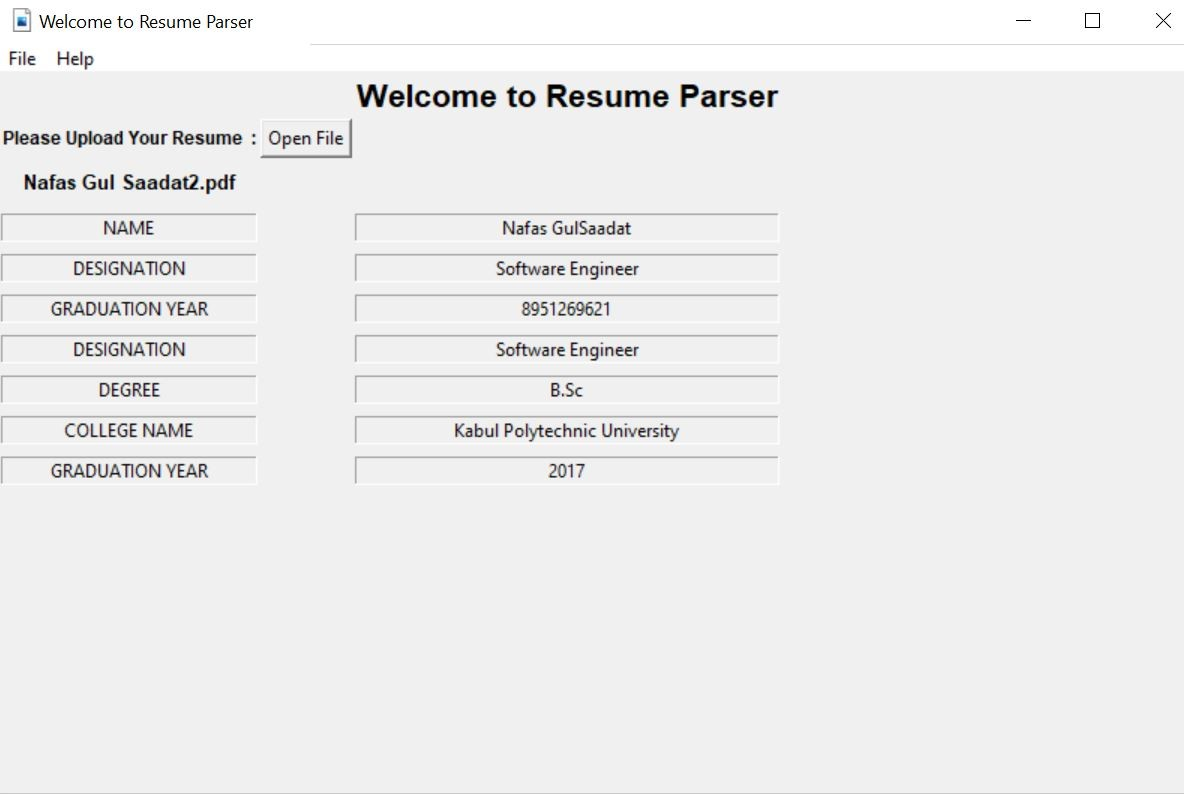


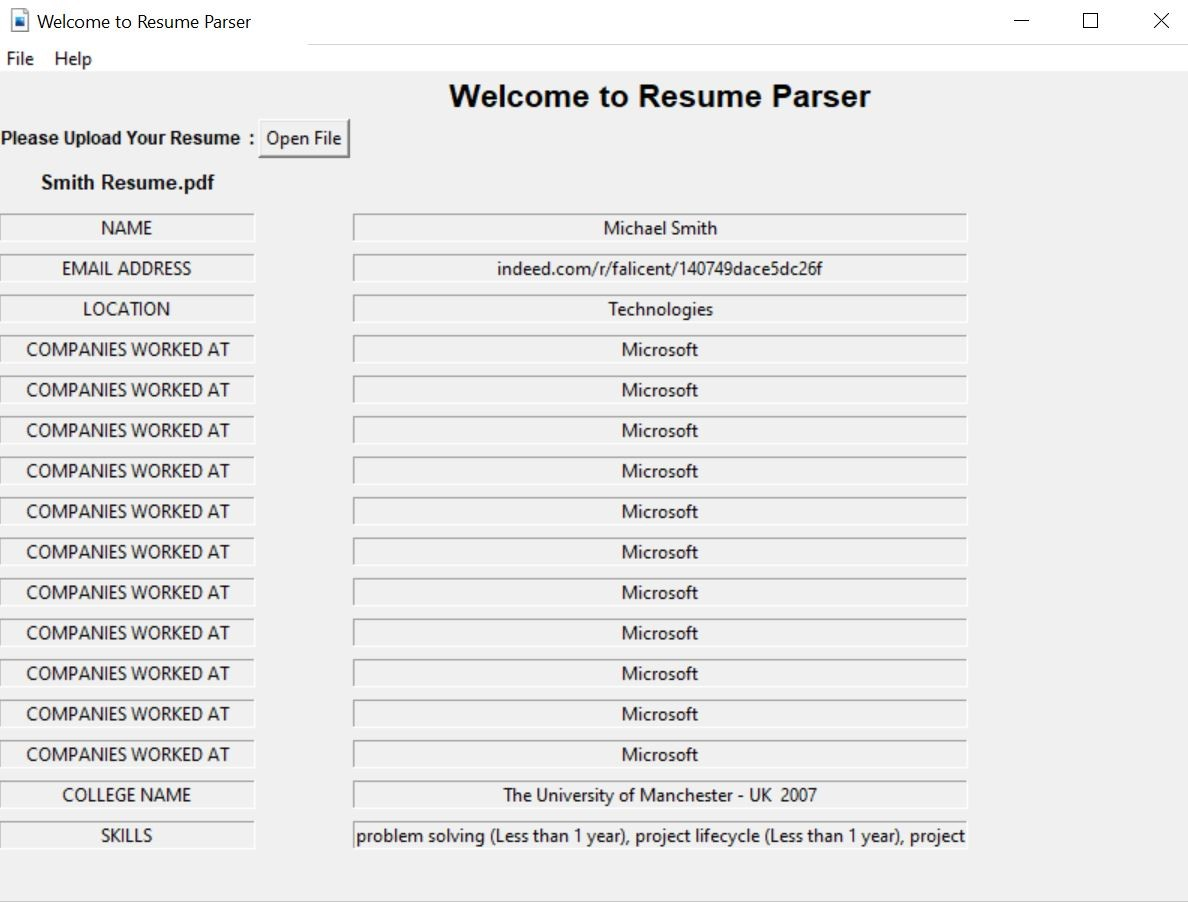

### Save to Txt file and can edit and print

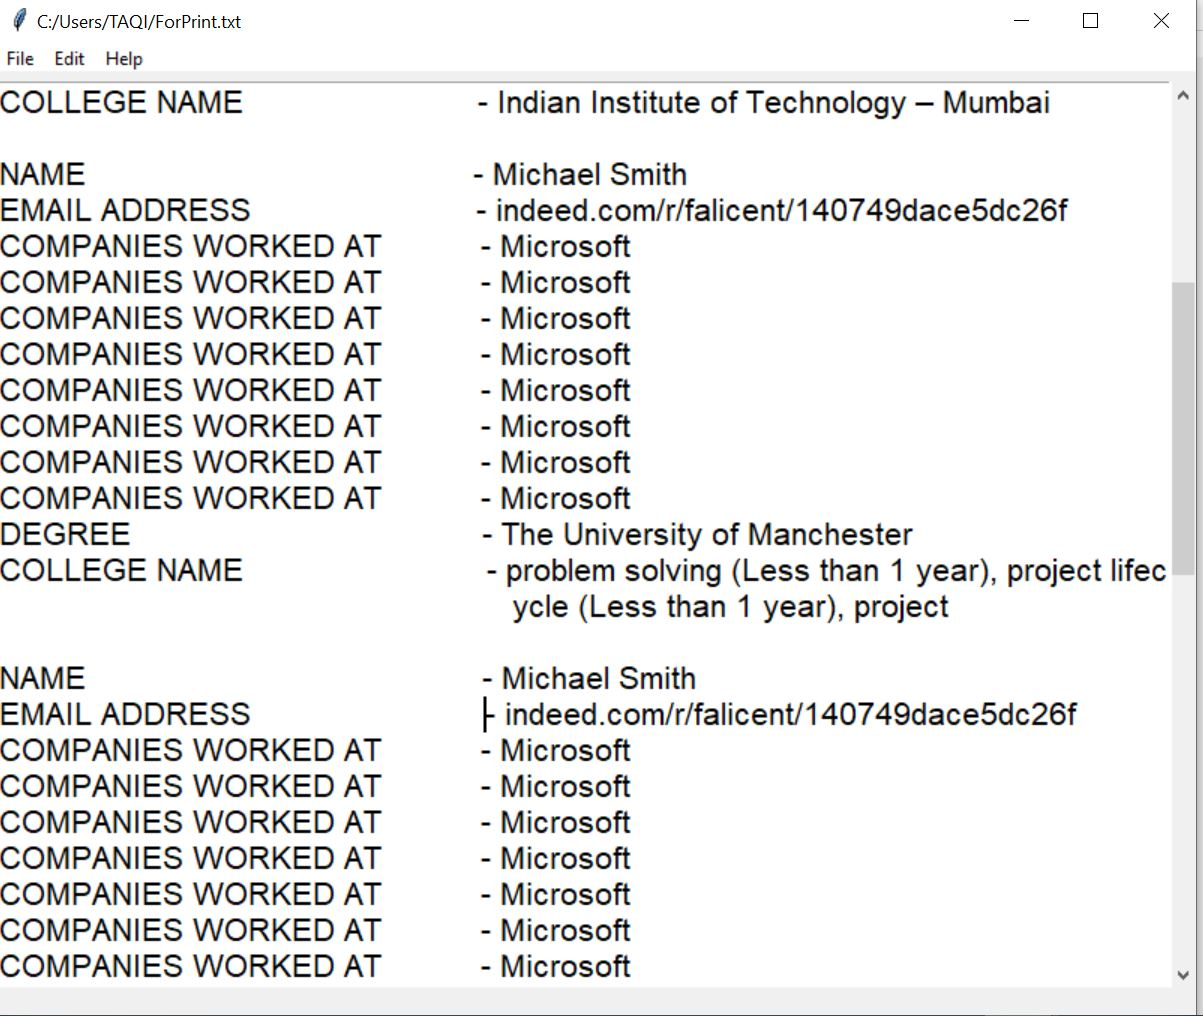